## **Single-Env Training**

In [9]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
env = gym.make("CartPole-v1")
env = Monitor(env, filename = os.path.join(log_path, "0.monitor.csv"))    # Monitor the environment for logging
env = DummyVecEnv([lambda: env])                                          # Wrap the environment in a DummyVecEnv


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = env, 
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)    # Tensorboard log folder location              # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=200,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 20000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "model_full_training")
model.save(model_save_path)

Using cpu device
Log path:   Training\2025-05-04_16-23-24   

Logging to Training\2025-05-04_16-23-24\PPO_1
Eval num_timesteps=1000, episode_reward=9.15 +/- 0.79
Episode length: 9.15 +/- 0.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.15     |
|    mean_reward     | 9.15     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=9.25 +/- 0.62
Episode length: 9.25 +/- 0.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.25     |
|    mean_reward     | 9.25     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 21.7     |
| time/              |          |
|    fps             | 1553     |


## **Multi-Env Training**
Faster then training in single environment

In [6]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

In [ ]:
# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
vec_env = make_vec_env(env_id = "CartPole-v1", 
                       n_envs = 8, 
                       monitor_dir = log_path)      # Create multiple environments and monitor them


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = vec_env, 
            n_steps = 256,                   # ← 重点：减小 rollout 长度
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)      # Tensorboard log folder location            # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=200,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(vec_env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 50000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "model_full_training")
model.save(model_save_path)

Using cpu device
Log path:   Training\2025-05-04_16-24-35   

Logging to Training\2025-05-04_16-24-35\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 7735     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.3        |
|    ep_rew_mean          | 27.3        |
| time/                   |             |
|    fps                  | 2406        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009111373 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    e

In [10]:
# 评估模型
# Test the model
import os; import tools
log_path = "Training\\2025-05-04_16-24-35"
PPO_Model_Path = os.path.join(log_path, "model_full_training")
tools.test_model("PPO", PPO_Model_Path, n_episodes=2, render = True)

Training\2025-05-04_16-24-35\model_full_training
Episode: 1 Score: [463.]
Episode: 2 Score: [260.]


Plotting path is:  Training\2025-05-04_16-24-35


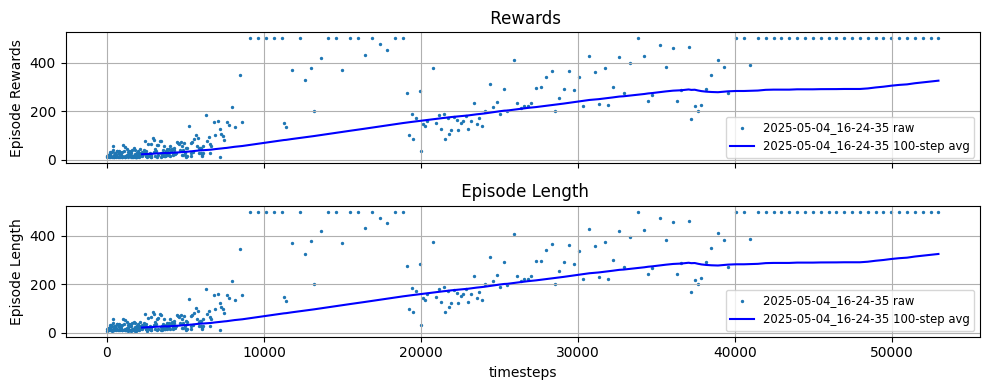

In [18]:
# 绘制结果
# Plotting the results
import tools
print("Plotting path is: ", log_path)
tools.plot_result(dirs=[log_path],
                  window = 100)

# # Plot Multi-Training Results
# tools.plot_result(dirs=["Training\\2025-05-04_16-23-24", "Training\\2025-05-04_16-24-35"],
#                   window = 100)

## **生成轨迹 Pair**

In [1]:
import os
import pandas as pd
import gym
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordVideo
from tools import test_model, plot_result

In [ ]:
from stable_baselines3 import PPO, DQN
import gymnasium as gym
import os

log_path = "Training\\2025-05-04_16-24-35"

model_pi_1_path = os.path.join(log_path, "model_full_training.zip")
model_pi_2_path = os.path.join(log_path, "model_at_reward_200.zip")

model_pi_1 = PPO.load(model_pi_1_path, device="cpu")
model_pi_2 = PPO.load(model_pi_2_path, device="cpu")

test_model("PPO", model_pi_1_path, n_episodes=10, render=False, record=False, traj=True)
test_model("PPO", model_pi_2_path, n_episodes=10, render=False, record=False, traj=True)

test_model("PPO", model_pi_1_path, n_episodes=10, render=False, record=True)
test_model("PPO", model_pi_2_path, n_episodes=10, render=False, record=True)

Training\2025-05-04_16-24-35\model_full_training.zip

Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-0.csv
Episode: 1 Score: 500.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-1.csv
Episode: 2 Score: 401.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-2.csv
Episode: 3 Score: 446.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-3.csv
Episode: 4 Score: 500.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-4.csv
Episode: 5 Score: 273.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-5.csv
Episode: 6 Score: 483.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-6.csv
Episode: 7 Score: 414.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-7.csv
Episode: 8 Score: 500.0
Trajectory saved to: Training\2025-05-04_16-24-35\trajectory\Pi-1-trajectory-8.csv
Episode

In [64]:
# RLHF 
#   需要把所有的 trajectory 裁成一样长输入
#   训练的 RLHF 会根据 trajectory 返回分数

# 加载轨迹数据
import numpy as np
import pandas as pd

df = pd.read_csv("Training\\2025-05-04_16-24-35\\trajectory\\Pi-1-trajectory-0.csv")

print(type(df))

print(df.columns)

print(df['reward'])            # 取出 reward 列

np.sum(np.array(df['reward'])) # 将 pandas 数据转为 numoy 数组

<class 'pandas.core.frame.DataFrame'>
Index(['episode', 'step', 'obs_0', 'obs_1', 'obs_2', 'obs_3', 'action',
       'reward'],
      dtype='object')
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
495    1.0
496    1.0
497    1.0
498    1.0
499    1.0
Name: reward, Length: 500, dtype: float64


np.float64(500.0)

In [114]:
import glob, os, re, pandas as pd

class RLHF_class:
    def __init__(self, path):

        # 初始化数据
        self.path = path
        self.reward_pi_1 = []
        self.reward_pi_2 = []
        self.traj_list_1 = []
        self.traj_list_2 = []
        self.choose_prob = None

        # 启动函数
        self.read_pattern()             # 一次性扫 Pi-1, Pi-2, … 各类文件
        self.compute_total_reward()     # 计算每个 Pi 的总奖励
        self.comput_RLHF_prob(self.reward_pi_1, self.reward_pi_2)
        self.store_trajectory()         # 将轨迹数据存储到 traj_list_1, traj_list_2 中

    def read_pattern(self):

        # 1. 扫描所有 Pi-*-trajectory-*.csv
        pattern = os.path.join(self.path, 'Pi-*-trajectory-*.csv')
        all_files = glob.glob(pattern)

        # 2. 按前缀 Pi-1, Pi-2… 分组
        groups = {}
        for fp in all_files:
            name = os.path.basename(fp)
            m = re.match(r'(Pi-\d+)-trajectory-.*\.csv', name)
            if not m:
                continue
            prefix = m.group(1)               # 比如 "Pi-1"
            groups.setdefault(prefix, []).append(fp)

        # 3. 为每个分组创建属性 data_base_1, data_base_2, …
        for idx, prefix in enumerate(sorted(groups.keys()), start=1):
            dfs = [pd.read_csv(f) for f in groups[prefix]]
            setattr(self, f"data_base_{idx}", dfs)
    
    def compute_total_reward(self):

        for data in self.data_base_1:
            reward = np.sum(data['reward'])
            self.reward_pi_1.append(reward)

        for data in self.data_base_2:
            reward = np.sum(data['reward'])
            self.reward_pi_2.append(reward)
    
    def store_trajectory(self):

        self.traj_list_1 = []
        self.traj_list_2 = []

        for data in self.data_base_1:
            
            x         = np.array(data['x'])
            x_dot     = np.array(data['x_dot'])
            theta     = np.array(data['theta'])
            theta_dot = np.array(data['theta_dot'])

            state     = np.array([x, x_dot, theta, theta_dot])
            self.traj_list_1.append(state)
        
        
        for data in self.data_base_2:
                
            x         = np.array(data['x'])
            x_dot     = np.array(data['x_dot'])
            theta     = np.array(data['theta'])
            theta_dot = np.array(data['theta_dot'])

            state     = np.array([x, x_dot, theta, theta_dot])
            self.traj_list_2.append(state)
    
    def comput_RLHF_prob(self, reward1, reward2):
        """
        计算 RLHF 概率
        Compute RLHF probability
        """
        self.choose_prob = np.exp(reward1) / (np.exp(reward1) + np.exp(reward2))
        






# 测试
Pi = RLHF_class("Training\\2025-05-04_16-24-35\\trajectory")


Pi.data_base_1[0]
Pi.traj_list_1[0]

print(Pi.reward_pi_1)
print(Pi.reward_pi_2)

Pi.choose_prob

[np.float64(294.0), np.float64(307.0), np.float64(500.0), np.float64(453.0), np.float64(310.0), np.float64(500.0), np.float64(414.0), np.float64(500.0), np.float64(337.0), np.float64(500.0)]
[np.float64(16.0), np.float64(78.0), np.float64(125.0), np.float64(156.0), np.float64(92.0), np.float64(169.0), np.float64(21.0), np.float64(206.0), np.float64(128.0), np.float64(118.0)]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])